# Calculations

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
plt.style.use('ggplot')

First we want to select all [members](https://www.wikidata.org/wiki/Property:P463) the [European Union](https://www.wikidata.org/wiki/Q458) and the [European Free Trade Association](https://www.wikidata.org/wiki/Q166546). A great way to start of is by using the [Wikipedia Query Service](https://query.wikidata.org/) and using the [Cats](https://www.wikidata.org/wiki/Wikidata:SPARQL_query_service/queries/examples#Cats) example and continue editing from there. Let's start by selecting all countries in Europe.

In [2]:
url = 'https://query.wikidata.org/sparql'
query = """
SELECT ?country ?countryLabel WHERE {
  ?country wdt:P463 wd:Q458.
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
"""
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

country_list = [entry['countryLabel']['value'] for entry in data['results']['bindings']]
print(country_list)
print('Length :', len(country_list))

['Ireland', 'Hungary', 'Spain', 'Belgium', 'Luxembourg', 'Finland', 'Sweden', 'Denmark', 'Poland', 'Lithuania', 'Italy', 'Austria', 'Greece', 'Portugal', 'France', 'United Kingdom', 'Germany', 'Estonia', 'Latvia', 'Czech Republic', 'Slovakia', 'Slovenia', 'Romania', 'Bulgaria', 'Croatia', 'Cyprus', 'Malta', 'Kingdom of the Netherlands']
Length : 28


Next, we want to apply a [`UNION`](https://en.wikibooks.org/wiki/SPARQL/UNION) to get countries from both the European Union and European Free Trade Association. Additionally we want to remove doubles that occur through the union, by using the `DISTINCT` modifier before `SELECT`.

In [3]:
url = 'https://query.wikidata.org/sparql'
query = """
SELECT DISTINCT ?country ?countryLabel 
WHERE 
{
  {?country wdt:P463 wd:Q166546} UNION {?country wdt:P463 wd:Q458}
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
"""
r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()

country_list = [entry['countryLabel']['value'] for entry in data['results']['bindings']]
print(country_list)
print('Length :', len(country_list))

['Ireland', 'Spain', 'Poland', 'Switzerland', 'United Kingdom', 'Iceland', 'Luxembourg', 'Romania', 'Germany', 'Malta', 'Austria', 'Denmark', 'Italy', 'Croatia', 'Cyprus', 'Estonia', 'Greece', 'Finland', 'Norway', 'France', 'Belgium', 'Lithuania', 'Portugal', 'Sweden', 'Hungary', 'Bulgaria', 'Slovakia', 'Slovenia', 'Latvia', 'Czech Republic', 'Liechtenstein', 'Kingdom of the Netherlands']
Length : 32


Let's define a utils function in [utils.py](utils.py) that returns a Pandas DataFrame with all the columns from the Wikidata query. 

In [4]:
import utils

query = """
SELECT DISTINCT ?country ?countryLabel ?capital ?capitalLabel ?mayor ?mayorLabel ?birth ?age ?population WHERE {
  {?country wdt:P463 wd:Q166546} UNION {?country wdt:P463 wd:Q458}
  ?country wdt:P36 ?capital.
  ?capital wdt:P1082 ?population.
  
  OPTIONAL {
    ?capital p:P6 ?statement.
    ?statement ps:P6 ?mayor.
    ?mayor wdt:P569 ?birth.
    BIND(year(now()) - year(?birth) AS ?age)
  } 
  
  FILTER NOT EXISTS { ?statement pq:P582 ?x }
  
  SERVICE wikibase:label { 
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
"""
df = utils.wikidata_query(query)
df.head()

,country,countryLabel,capital,capitalLabel,mayor,mayorLabel,birth,age,population
0,http://www.wikidata.org/entity/Q39,Switzerland,http://www.wikidata.org/entity/Q70,Bern,http://www.wikidata.org/entity/Q121896,Alec von Graffenried,1962-08-16,56,141833.0
1,http://www.wikidata.org/entity/Q45,Portugal,http://www.wikidata.org/entity/Q597,Lisbon,http://www.wikidata.org/entity/Q20017756,Fernando Medina,1973-03-10,45,506892.0
2,http://www.wikidata.org/entity/Q35,Denmark,http://www.wikidata.org/entity/Q1748,Copenhagen,http://www.wikidata.org/entity/Q113921,Frank Jensen,1961-05-28,57,602481.0
3,http://www.wikidata.org/entity/Q215,Slovenia,http://www.wikidata.org/entity/Q437,Ljubljana,http://www.wikidata.org/entity/Q220521,Zoran Janković,1953-01-01,65,280310.0
4,http://www.wikidata.org/entity/Q229,Cyprus,http://www.wikidata.org/entity/Q3856,Nicosia,http://www.wikidata.org/entity/Q16331287,Constantinos Yiorkadjis,1968-01-01,50,330000.0


## Final Query for each Country

Let's collect all mayors and their birth cities with Wikidata. We create the script [load_european_mayor.py](load_european_mayor.py) which collects and cleans the data based on the results from the following query. In this case we collect the information for all mayors in Germany.

In [5]:
query="""
SELECT DISTINCT 
  ?city ?cityLabel ?city_coordinates ?population 
  ?mayor ?mayorLabel ?genderLabel ?birth ?age ?start_date ?duration
  ?birth_country ?birth_countryLabel ?birth_city ?birth_cityLabel ?birth_city_coordinates 
WHERE {
  ?city wdt:P17 wd:Q183.
  ?city wdt:P31/wdt:P279* wd:Q515.
  OPTIONAL { ?city wdt:P1082 ?population. }
  ?city wdt:P625 ?city_coordinates.
  ?city p:P6 ?statement.

  ?statement ps:P6 ?mayor.
  ?statement pq:P580 ?start_date.
  BIND(year(now()) - year(?start_date) AS ?duration)

  OPTIONAL { ?mayor wdt:P21 ?gender. }
  OPTIONAL { 
    ?mayor wdt:P569 ?birth.
    BIND(year(now()) - year(?birth) AS ?age)
  }

  # Remove all mayors that have an end time
  FILTER NOT EXISTS { ?statement pq:P582 ?y. }
  # Remove all mayors that are not alive
  FILTER NOT EXISTS { ?mayor wdt:P570 ?z. }

  OPTIONAL {
    ?mayor wdt:P19 ?birth_city.
    ?birth_city wdt:P625 ?birth_city_coordinates.
    ?birth_city wdt:P17 ?birth_country.

    # Remove all historic countries
    FILTER NOT EXISTS { ?birth_country wdt:P31 wd:Q3024240. }
  }

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". 
  }
}
ORDER BY DESC (?population)
"""

df = utils.wikidata_query(query)
df.head(10)

,city,cityLabel,city_coordinates,population,mayor,mayorLabel,genderLabel,birth,age,start_date,duration,birth_country,birth_countryLabel,birth_city,birth_cityLabel,birth_city_coordinates
0,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666),3574830.0,http://www.wikidata.org/entity/Q102844,Michael Müller,male,1964-12-09,54.0,2014-12-11,4,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q64,Berlin,Point(13.383333333 52.516666666)
1,http://www.wikidata.org/entity/Q1055,Hamburg,Point(10.0 53.55),1810438.0,http://www.wikidata.org/entity/Q971774,Peter Tschentscher,male,1966-01-20,52.0,2018-03-28,0,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q1209,Bremen,Point(8.5913 53.347266666)
2,http://www.wikidata.org/entity/Q1726,Munich,Point(11.5755 48.137194444),1464301.0,http://www.wikidata.org/entity/Q1083811,Christine Strobl,female,1961-03-02,57.0,2014-05-21,4,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q1726,Munich,Point(11.5755 48.137194444)
3,http://www.wikidata.org/entity/Q1726,Munich,Point(11.5755 48.137194444),1464301.0,http://www.wikidata.org/entity/Q1222671,Dieter Reiter,male,1958-05-19,60.0,2014-05-01,4,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q503737,Rain,Point(10.916666666 48.683333333)
4,http://www.wikidata.org/entity/Q1726,Munich,Point(11.5755 48.137194444),1464301.0,http://www.wikidata.org/entity/Q1705661,Josef Schmid,male,1969-09-27,49.0,2014-05-21,4,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q1726,Munich,Point(11.5755 48.137194444)
5,http://www.wikidata.org/entity/Q365,Cologne,Point(6.957777777 50.942222222),1075935.0,http://www.wikidata.org/entity/Q19285371,Henriette Reker,female,1956-12-09,62.0,2015-10-02,3,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q365,Cologne,Point(6.957777777 50.942222222)
6,http://www.wikidata.org/entity/Q1794,Frankfurt,Point(8.679722222 50.113611111),736414.0,http://www.wikidata.org/entity/Q96506,Peter Feldmann,male,1958-10-07,60.0,2012-07-01,6,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q486562,Helmstedt,Point(11.010555555 52.228055555)
7,http://www.wikidata.org/entity/Q1209,Bremen,Point(8.5913 53.347266666),661000.0,http://www.wikidata.org/entity/Q1045675,Carsten Sieling,male,1959-01-13,59.0,2015-01-01,3,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q16079,Nienburg/Weser,Point(9.206944444 52.641111111)
8,http://www.wikidata.org/entity/Q1718,Düsseldorf,Point(6.816666666 51.216666666),613230.0,http://www.wikidata.org/entity/Q17198510,Thomas Geisel,male,1963-10-26,55.0,2014-09-01,4,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q163973,Ellwangen (Jagst),Point(10.130555555 48.961111111)
9,http://www.wikidata.org/entity/Q2066,Essen,Point(7.013055555 51.450833333),590194.0,http://www.wikidata.org/entity/Q2425595,Thomas Kufen,male,1973-08-05,45.0,2015-01-01,3,http://www.wikidata.org/entity/Q183,Germany,http://www.wikidata.org/entity/Q2066,Essen,Point(7.013055555 51.450833333)


It appears that [Munich](https://www.wikidata.org/wiki/Q1726) has three mayors currently running, which is after double checking indeed the case. Take note that Wikidata is continuously updated and information can be incomplete for certain items.

# All Mayors in Europe

After collecting the data we can now explore it.

In [6]:
df = pd.read_csv('data/european_mayors.csv')
df.head()

,country,city,cityLabel,population,mayor,mayorLabel,genderLabel,birth,age,start_date,duration,birth_country,birth_countryLabel,birth_city,birth_cityLabel,city_lon,city_lat,birth_city_lon,birth_city_lat,distance
0,Ireland,http://www.wikidata.org/entity/Q1761,Dublin,553165.0,http://www.wikidata.org/entity/Q41536567,Mícheál Mac Donncha,male,1965-03-11,53.0,2017-06-26,1,http://www.wikidata.org/entity/Q27,Ireland,http://www.wikidata.org/entity/Q1761,Dublin,-6.265833,53.342500,-6.265833,53.342500,0.000000
1,Spain,http://www.wikidata.org/entity/Q8818,Valencia,787808.0,http://www.wikidata.org/entity/Q9012047,Joan Ribó,male,1947-09-17,71.0,2017-01-01,1,http://www.wikidata.org/entity/Q29,Spain,http://www.wikidata.org/entity/Q16697,Manresa,-0.375000,39.466667,1.829167,41.726389,312667.921184
2,Spain,http://www.wikidata.org/entity/Q15688,Ávila,58149.0,http://www.wikidata.org/entity/Q29366430,José Luis Rivas,male,1950-01-01,68.0,2015-05-24,3,http://www.wikidata.org/entity/Q29,Spain,http://www.wikidata.org/entity/Q15688,Ávila,-4.696222,40.654347,-4.696222,40.654347,0.000000
3,Spain,http://www.wikidata.org/entity/Q494693,Torrelavega,52034.0,http://www.wikidata.org/entity/Q25408727,José Manuel Cruz Viadero,male,1954-08-15,64.0,2015-06-13,3,http://www.wikidata.org/entity/Q29,Spain,http://www.wikidata.org/entity/Q19460136,"Ajo, Cantabria",-4.045833,43.353056,-3.609722,43.480556,38054.270362
4,Spain,http://www.wikidata.org/entity/Q8692,Bilbao,345110.0,http://www.wikidata.org/entity/Q5951349,Juan María Aburto,male,1961-03-28,57.0,2015-01-01,3,http://www.wikidata.org/entity/Q29,Spain,http://www.wikidata.org/entity/Q8692,Bilbao,-2.953333,43.262222,-2.953333,43.262222,0.000000


## How many Mayors (with birth place) are per Country in Wikidata?

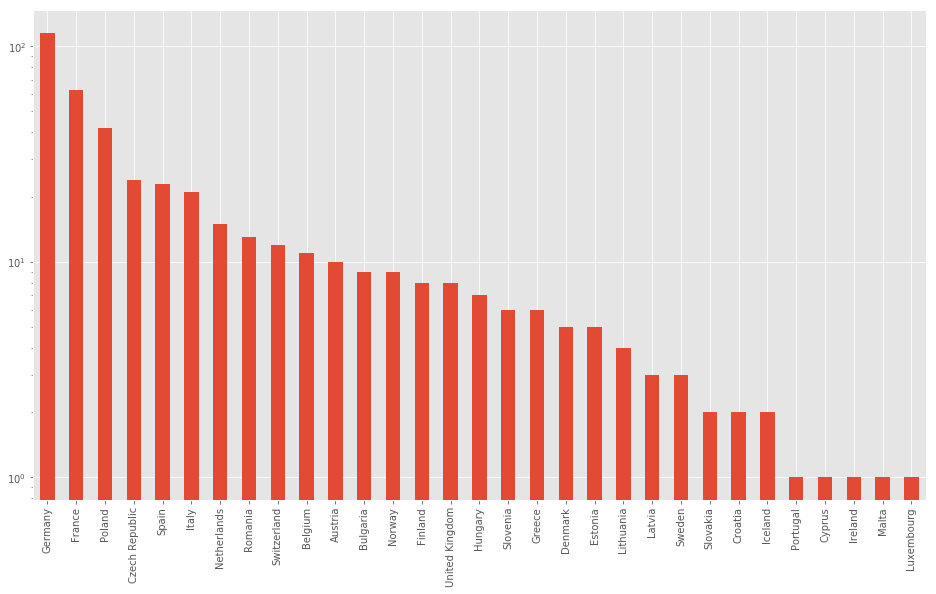

In [7]:
df.dropna()['country'].value_counts().plot(kind='bar', color='C0', logy=True, figsize=(16, 9));

# How does that look like on the Map?

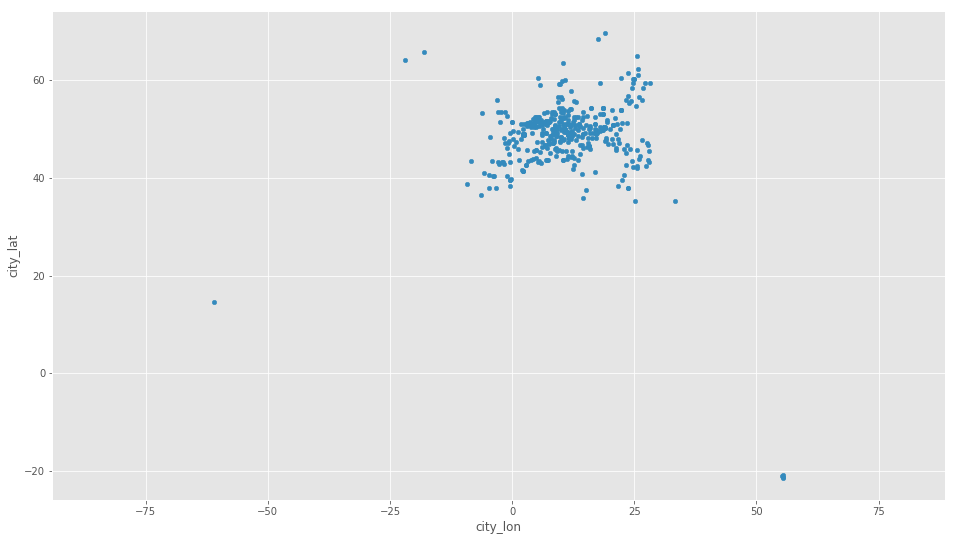

In [8]:
df.dropna().plot(kind='scatter', x='city_lon', y='city_lat', figsize=(16, 9))
plt.axis('equal');

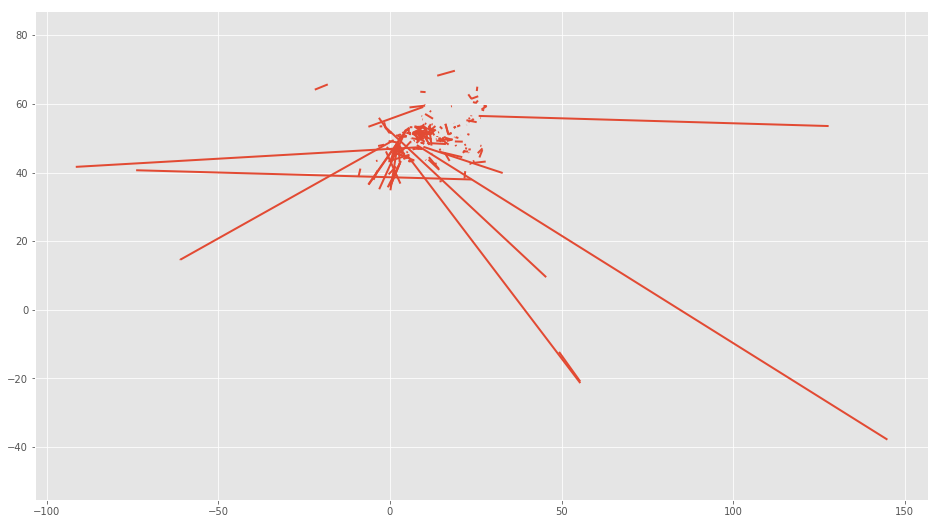

In [9]:
from matplotlib.collections import LineCollection

df_plot = df.dropna()
lines = [[(lon0, lat0), (lon1, lat1)] 
         for lon0, lat0, lon1, lat1 in df_plot[['city_lon', 
                                                'city_lat', 
                                                'birth_city_lon', 
                                                'birth_city_lat']].values]

line_collection = LineCollection(lines, linewidths=2)

plt.figure(figsize=(16, 9))
plt.gca().add_collection(line_collection)
plt.gca().autoscale()
plt.axis('equal');

# What is the Average Age of a Mayor?

We can see that 55 years is the prime age to be a mayor

Average age : 55.27 (+/- 9.75)


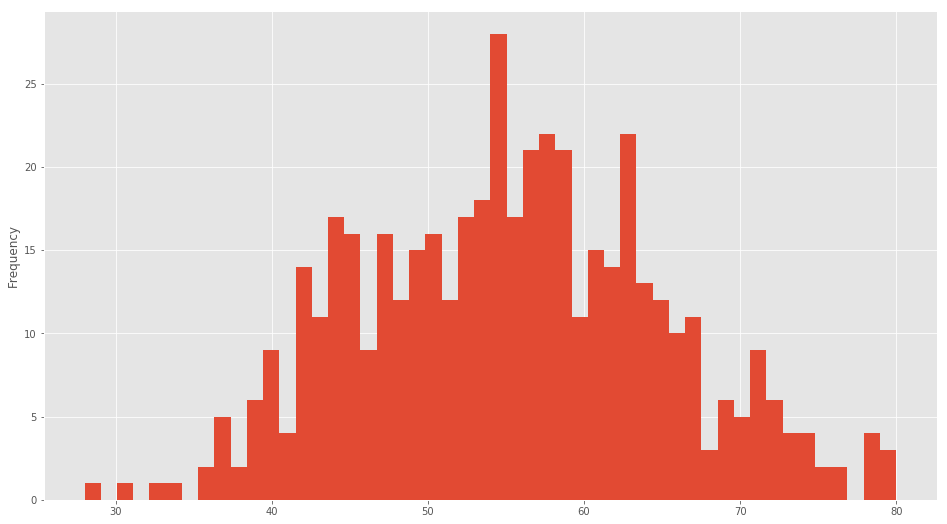

In [10]:
df['age'].plot(kind='hist', bins=50, figsize=(16, 9));
print('Average age : {:.2f} (+/- {:.2f})'.format(df['age'].mean(), df['age'].std()))

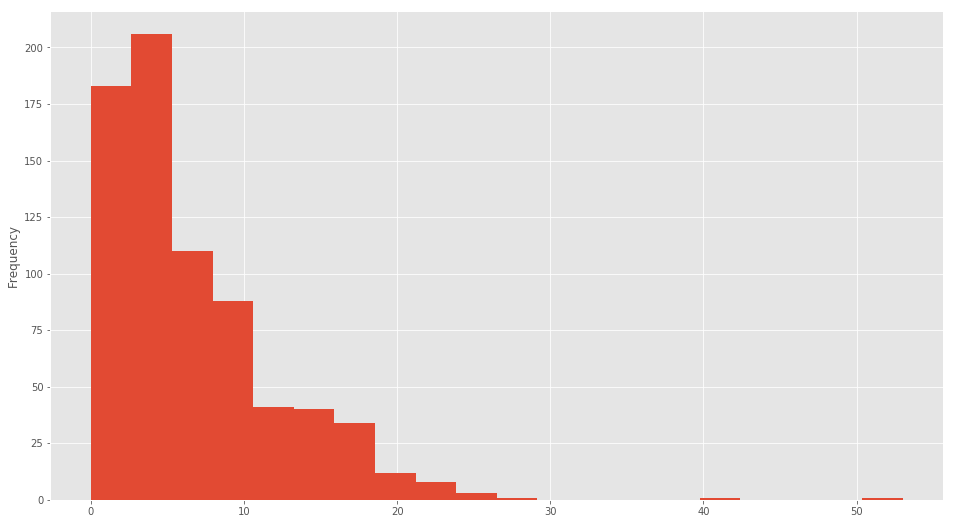

In [11]:
df['duration'].plot(kind='hist', bins=20, figsize=(16, 9));

In [12]:
df.sort_values(by='distance', ascending=False).head()

,country,city,cityLabel,population,mayor,mayorLabel,genderLabel,birth,age,start_date,duration,birth_country,birth_countryLabel,birth_city,birth_cityLabel,city_lon,city_lat,birth_city_lon,birth_city_lat,distance
382,Germany,http://www.wikidata.org/entity/Q2833,Freiburg im Breisgau,227590.0,http://www.wikidata.org/entity/Q109550,Dieter Salomon,male,1960-08-09,58.0,2002-05-05,16,http://www.wikidata.org/entity/Q408,Australia,http://www.wikidata.org/entity/Q3141,Melbourne,7.849722,47.994722,144.961389,-37.820556,1.639172e+07
640,France,http://www.wikidata.org/entity/Q249884,Saint-Pierre,84063.0,http://www.wikidata.org/entity/Q3309639,Michel Fontaine,male,1952-05-06,66.0,2001-01-01,17,http://www.wikidata.org/entity/Q142,France,http://www.wikidata.org/entity/Q239078,Romans-sur-Isère,55.477778,-21.341944,5.050833,45.045556,8.951750e+06
550,Greece,http://www.wikidata.org/entity/Q1524,Athens,664046.0,http://www.wikidata.org/entity/Q719130,Giorgos Kaminis,male,1954-07-15,64.0,2010-12-29,8,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q60,New York City,23.716111,37.979444,-73.940000,40.670000,7.942163e+06
87,Switzerland,http://www.wikidata.org/entity/Q72,Zürich,415682.0,http://www.wikidata.org/entity/Q123363,Corine Mauch,female,1960-05-28,58.0,2009-05-01,9,http://www.wikidata.org/entity/Q30,United States of America,http://www.wikidata.org/entity/Q487977,Iowa City,8.540000,47.378611,-91.525000,41.655833,7.401167e+06
609,France,http://www.wikidata.org/entity/Q30974,Rouen,110169.0,http://www.wikidata.org/entity/Q3574148,Yvon Robert,male,1949-11-10,69.0,2014-01-01,4,http://www.wikidata.org/entity/Q142,France,http://www.wikidata.org/entity/Q81621,Fort-de-France,1.102500,49.443056,-61.069444,14.607222,6.782640e+06


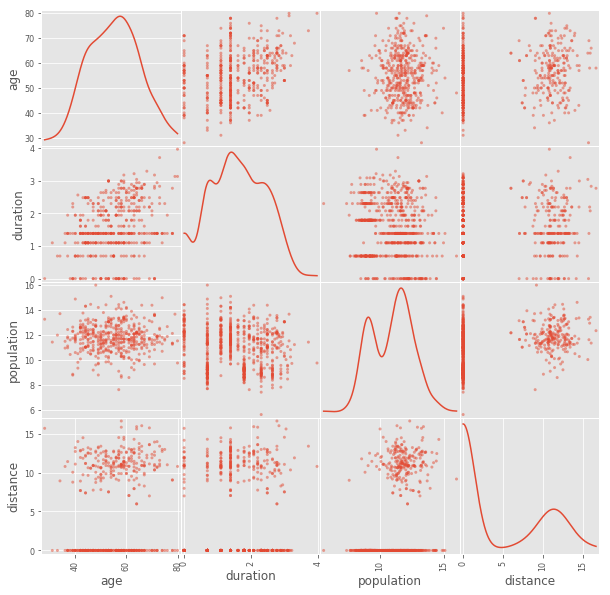

In [13]:
from pandas.plotting import scatter_matrix

df_plot = df[['age', 'duration', 'population', 'distance']].copy()
for col in ['population', 'duration']:
    df_plot[col] = df_plot[col].apply(lambda x: np.log(x) if x > 0 else 0)
df_plot['distance'] = df_plot['distance'].apply(lambda x: np.log(x) if x > 0 else 0)
scatter_matrix(df_plot, alpha=0.5, figsize=(10, 10), diagonal='kde');